In [1]:
#from keras_transformer import get_model
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.optimizers import Adam
from TransformerEncoder import TransformerEncoder
from TrainablePositionalEmbeddings import TransformerPositionalEmbedding
from keras.layers import Input,Dense,Embedding,Lambda,TimeDistributed,LSTM, Reshape, Dropout
from keras.models import Model

Using TensorFlow backend.


## data

In [2]:
sku_id = 30851
n_in = 16
#data load
df = pd.read_csv('data/sku_day_20191023_v2.csv')
data_beer = df[df["sku_id"] == sku_id].copy()
data_beer['time'] = pd.to_datetime(data_beer['time'], format='%Y-%m')
data_beer['week'] = ((data_beer['time'] - pd.datetime(year=2014, month=1, day=6)).dt.days / 7).astype(int)
data_beer['monthly'] = data_beer['time'].apply(lambda x: pd.datetime(year=x.year, month=x.month, day=1))
data_beer_week = data_beer.groupby(['week'])['y'].sum().to_frame().sort_values(['week']).reset_index()
data_beer_week = pd.DataFrame(data_beer_week.y.values).values

#data perpare
#n_in = n_seq * n_steps
n_out = 1
df = pd.DataFrame(data_beer_week)
cols = list()
for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
for i in range(0, n_out):
    cols.append(df.shift(-i))
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
data_supervised = agg.values

In [3]:
mu = pd.Series(data_supervised.reshape(-1,)).mean()
sigma = pd.Series(data_supervised.reshape(-1,)).std()

In [4]:
data = data_supervised

In [5]:
data_supervised[data_supervised<mu-sigma]=0
data_supervised[(data_supervised>=mu-sigma) & (data_supervised<mu)]=1
data_supervised[(data_supervised>=mu) & (data_supervised<mu + sigma)]=2
data_supervised[(data_supervised>=mu+sigma) & (data_supervised<mu + 2*sigma)]=3
data_supervised[data_supervised>=mu+2*sigma]=4

In [6]:
data = data_supervised

In [7]:
data_train, data_test = train_test_split(data, test_size=0.05, random_state=42)
#data_train, data_test = data

In [8]:
x_train = data_train[:,:-1]
y_train = to_categorical(data_train[:,-1]) # one-hot
x_test = data_test[:,:-1]
y_test = to_categorical(data_test[:,-1]) # one-hot

## Model

In [2]:
#hyper parameter
input_seq_len = 16
input_dim = 1
hidden_dim = 30
positional_ff_dim = 32

In [3]:
def build_model():
    '''
    embedding: uniform initialization
    encoder + softmax
    '''
    encoder_inputs = Input((16,),name='Encoder_input')
    next_step_input = Embedding(5,hidden_dim,input_length=16)(encoder_inputs)
    next_step_input = Dropout(0.2)(next_step_input)


    positional_embedding_layer    = TransformerPositionalEmbedding(name='Positional_embedding')
    next_step_input               = positional_embedding_layer(next_step_input)

    next_step_input,attention =TransformerEncoder(hidden_dim,
                                                             1,
                                                             hidden_dim,
                                                             hidden_dim,
                                                             positional_ff_dim,
                                                             dropout_rate= 0.1,
                                                             name= 'Transformer')(next_step_input)
    '''
    next_step_input,attention =TransformerEncoder(hidden_dim,
                                                         1,
                                                         hidden_dim,
                                                         hidden_dim,
                                                         positional_ff_dim,
                                                         dropout_rate= 0.1,
                                                         name= 'Transformer1')(next_step_input)
    
    '''
    next_step_input = Lambda(lambda x: x[:,0])(next_step_input)
    next_step_input = Dropout(0.5)(next_step_input)
    outputs = Dense(5, activation='softmax')(next_step_input)
    model = Model(encoder_inputs, outputs)
    model.summary()
    
    return model

In [4]:
model = build_model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      (None, 16)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 16, 30)       150         Encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 16, 30)       0           embedding_1[0][0]                
__________________________________________________________________________________________________
Positional_embedding (Transform (None, 16, 30)       480         dropout_1[0][0]                  
____________________________________________________________________________________________

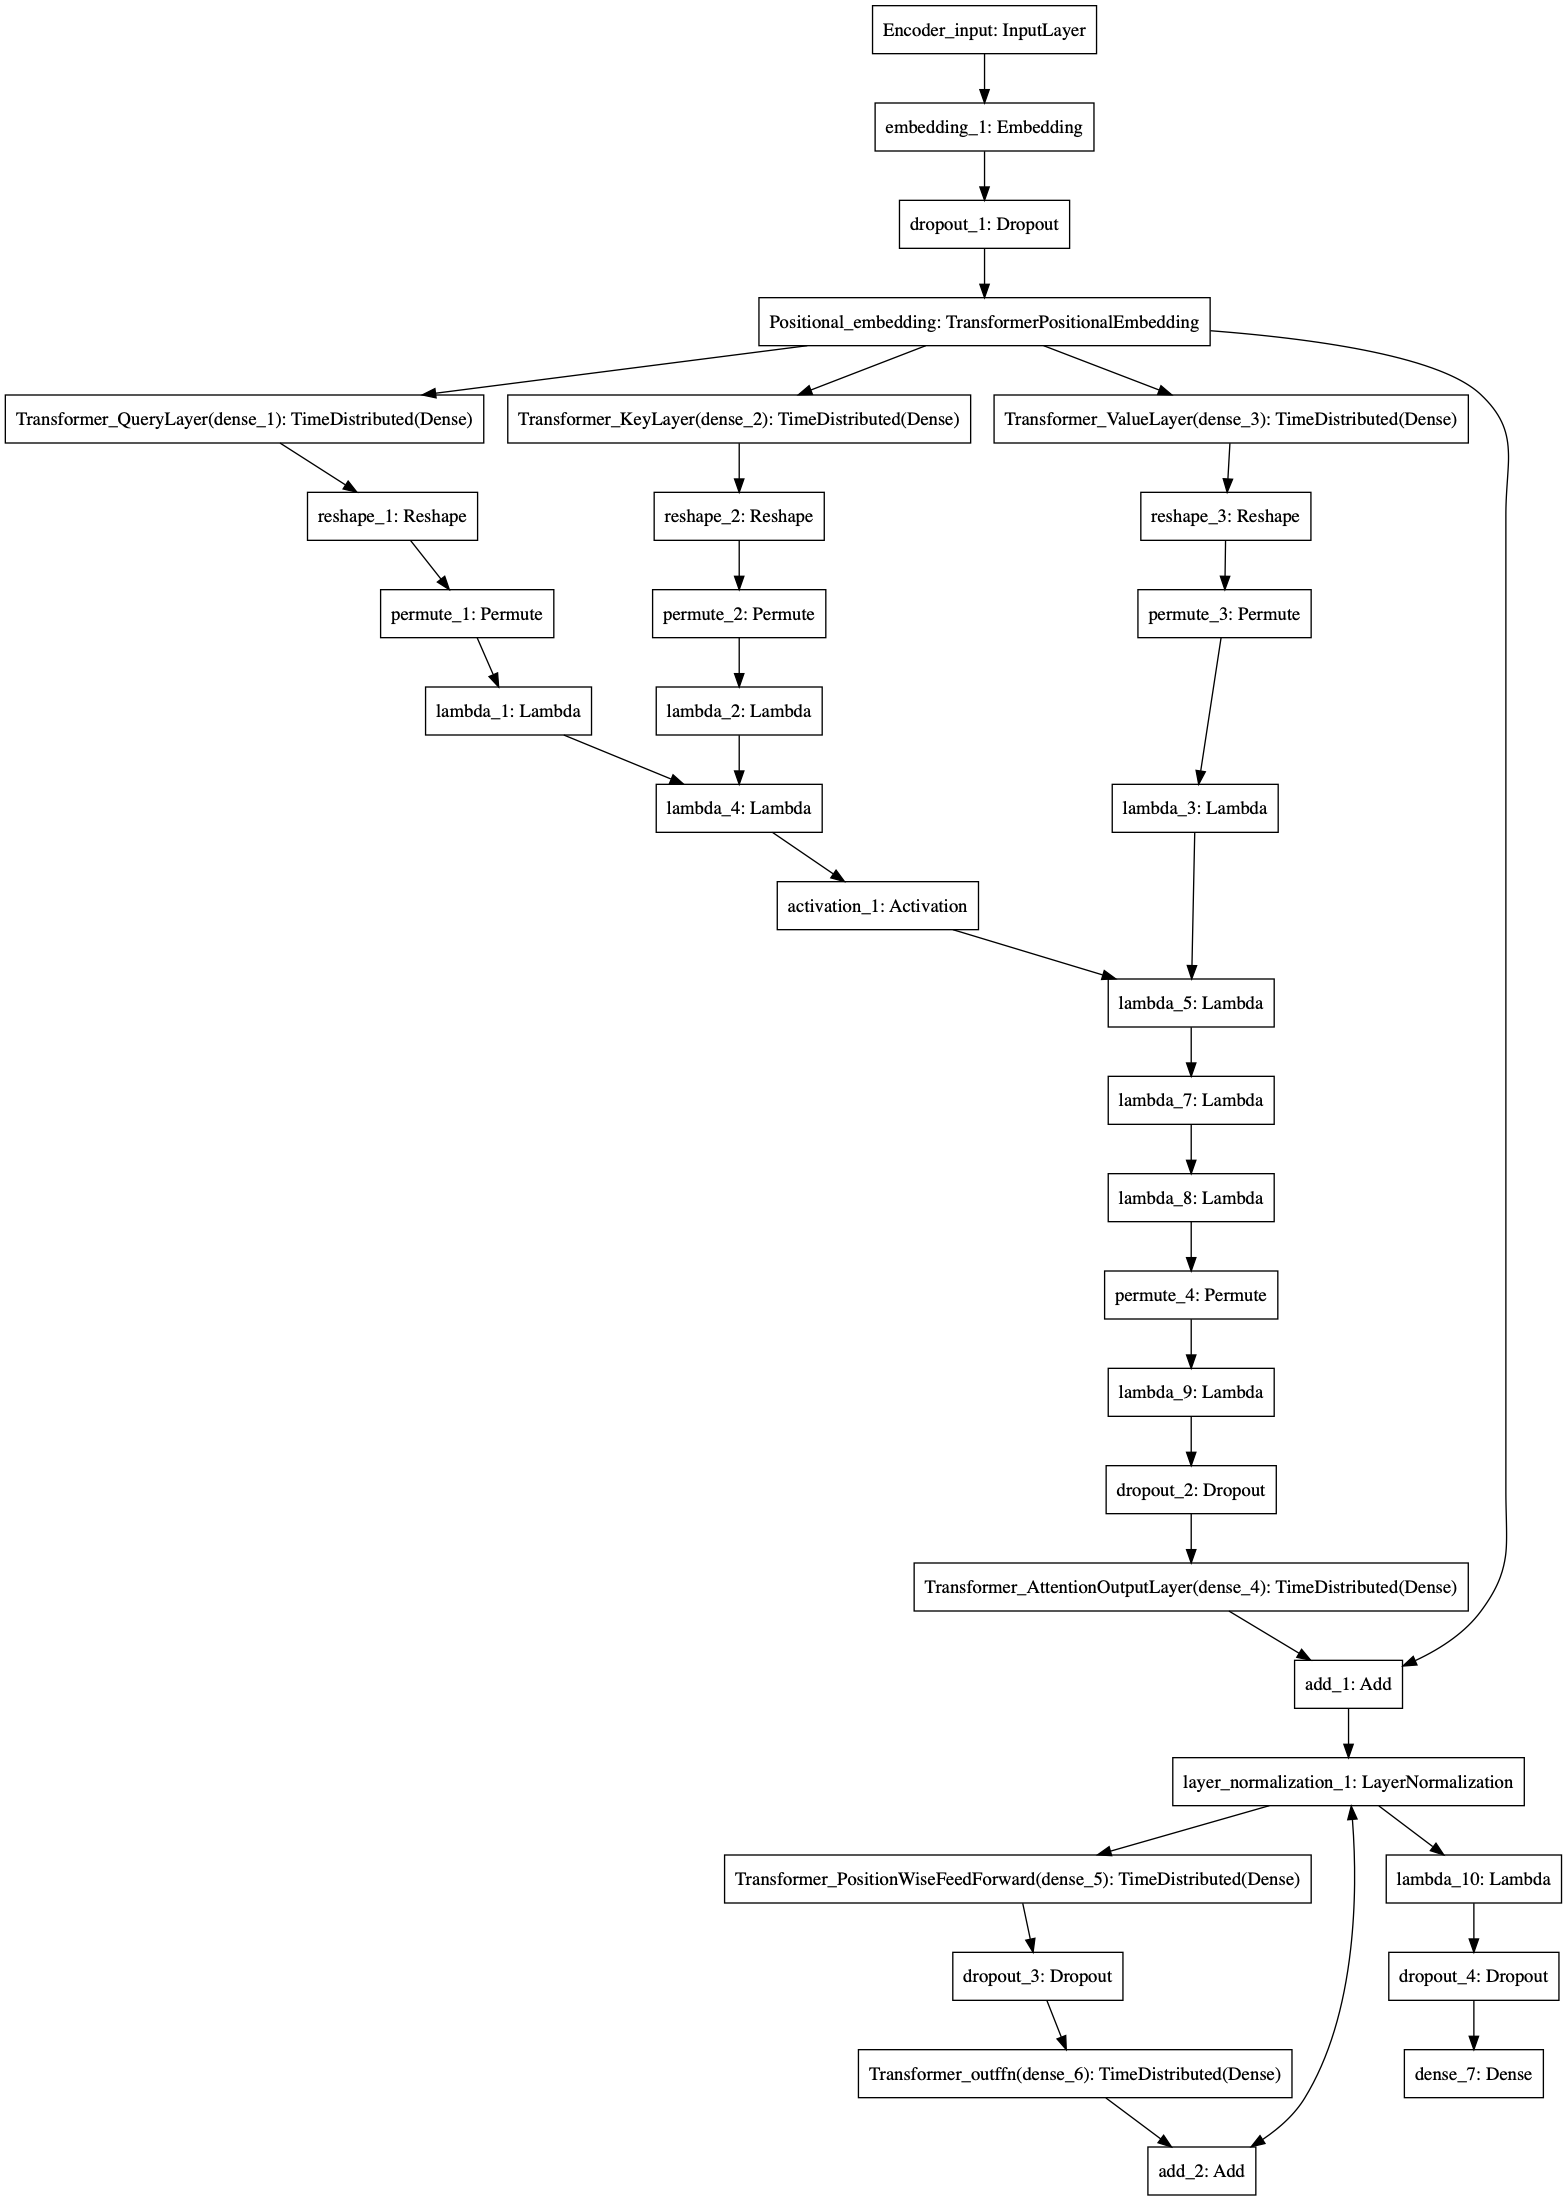

In [5]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot_dist.png', expand_nested=True)

In [12]:
model.compile(optimizer=Adam(),loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(x_train, y_train, epochs=200)

/Users/zxy/project/.keras/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/200
203/203 [==============================] - 1s 3ms/step - loss: 1.8945 - accuracy: 0.3695
Epoch 2/200
203/203 [==============================] - 0s 161us/step - loss: 1.6192 - accuracy: 0.4975
Epoch 3/200
203/203 [==============================] - 0s 148us/step - loss: 1.6368 - accuracy: 0.4581
Epoch 4/200
203/203 [==============================] - 0s 129us/step - loss: 1.4461 - accuracy: 0.4828
Epoch 5/200
203/203 [==============================] - 0s 137us/step - loss: 1.4367 - accuracy: 0.5320
Epoch 6/200
203/203 [==============================] - 0s 145us/step - loss: 1.4673 - accuracy: 0.5123
Epoch 7/200
203/203 [==============================] - 0s 136us/step - loss: 1.3816 - accuracy: 0.5123
Epoch 8/200
203/203 [==============================] - 0s 135us/step - loss: 1.3460 - accuracy: 0.5271
Epoch 9/200
203/203 [==============================] - 0s 128us/step - loss: 1.3542 - accuracy: 0.5665
Epoch 10/200
203/203 [==============================] - 0s 130us/step - los

## Validation

In [14]:
loss = model.evaluate(x_test[:8,:],y_test[:8,:])

8/8 [==============================] - 0s 12ms/step


In [15]:
loss

[1.2440152168273926, 0.5]

In [57]:
preds = model.predict(x_test)
'''
for i in range(preds.shape[0]):
    for j in range(preds.shape[1]):
        preds[i,j] = round(preds[i,j],2)
'''
preds = np.round(preds, 2)

In [58]:
print('break point: ', 0,round(mu - sigma,2), round(mu,2), round(mu+sigma,2), round(mu+2*sigma,2))

break point:  0 145.96 3451.46 6756.95 10062.45


In [59]:
print(preds) # Probability distribution

[[0.   0.9  0.09 0.01 0.  ]
 [0.05 0.94 0.01 0.   0.  ]
 [0.01 0.98 0.   0.   0.  ]
 [0.01 0.86 0.12 0.   0.  ]
 [0.   0.29 0.13 0.55 0.03]
 [0.04 0.76 0.2  0.   0.  ]
 [0.   0.92 0.07 0.   0.  ]
 [0.01 0.66 0.04 0.27 0.03]
 [0.06 0.63 0.3  0.01 0.  ]
 [0.   0.03 0.22 0.63 0.12]
 [0.02 0.89 0.09 0.01 0.  ]]


In [60]:
preds = model.predict(x_test)
preds = np.argmax(preds, axis=1)
preds # categorical output

array([1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1])

In [61]:
y_test = np.argmax(y_test, axis=1)
y_test # true category

array([2, 0, 2, 2, 3, 1, 1, 1, 1, 4, 1])

In [76]:
data_test[:,-1] # true volume

array([ 6609.6 ,   116.64,  4633.2 ,  3499.2 ,  7795.44,  1581.12,
         952.56,  3402.  ,   220.32, 13186.8 ,   758.16])

In [85]:
from sklearn.metrics import accuracy_score, classification_report

In [88]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.57      0.80      0.67         5
           2       1.00      0.33      0.50         3
           3       0.33      1.00      0.50         1
           4       0.00      0.00      0.00         1

    accuracy                           0.55        11
   macro avg       0.38      0.43      0.33        11
weighted avg       0.56      0.55      0.48        11



In [17]:
model.save('./model.h5')

TypeError: can't pickle _thread.RLock objects